In [0]:
import os
import zipfile
import random
import tensorflow as tf
from shutil import copyfile

In [0]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2020-05-29 11:08:01--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 2.22.94.11, 2a02:26f0:7b:985::e59, 2a02:26f0:7b:984::e59
Connecting to download.microsoft.com (download.microsoft.com)|2.22.94.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  71.4MB/s    in 11s     

2020-05-29 11:08:13 (70.4 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [0]:
local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [0]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [0]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [0]:
print('Total training cats: '+str(len(os.listdir("/tmp/cats-v-dogs/training/cats/"))))
print('Total training dogs: '+str(len(os.listdir("/tmp/cats-v-dogs/training/dogs/"))))
print('Total validation cats: '+str(len(os.listdir("/tmp/cats-v-dogs/testing/cats/"))))
print('Total validation dogs: '+str(len(os.listdir("/tmp/cats-v-dogs/testing/dogs/"))))

Total training cats: 11250
Total training dogs: 11250
Total validation cats: 1250
Total validation dogs: 1250


In [0]:
import keras
model = keras.models.Sequential([
                                 keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(150,150,3)),
                                 keras.layers.MaxPooling2D(2,2),
                                 keras.layers.Conv2D(32, (3,3), activation='relu'),
                                 keras.layers.MaxPooling2D(2,2), 
                                 keras.layers.Conv2D(64, (3,3), activation='relu'), 
                                 keras.layers.MaxPooling2D(2,2),
                                 # Flatten the results to feed into a DNN
                                 keras.layers.Flatten(), 
                                 # 512 neuron hidden layer
                                 keras.layers.Dense(512, activation='relu'), 
                                 # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
                                 keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)            

In [0]:
from keras.preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))


Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [0]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['acc']
              )

In [0]:
history = model.fit_generator(
    train_generator,
    epochs = 10,
    validation_data = validation_generator,
    verbose = 1
)

Epoch 1/10
 44/225 [====>.........................] - ETA: 2:41 - loss: 0.7027 - acc: 0.5118

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 198s 879ms/step - loss: 0.6494 - acc: 0.5996 - val_loss: 0.5648 - val_acc: 0.6896
Epoch 2/10
225/225 [==============================] - 190s 846ms/step - loss: 0.5859 - acc: 0.6846 - val_loss: 0.5732 - val_acc: 0.7448
Epoch 3/10
225/225 [==============================] - 190s 846ms/step - loss: 0.5455 - acc: 0.7178 - val_loss: 0.4420 - val_acc: 0.7800
Epoch 4/10
225/225 [==============================] - 190s 844ms/step - loss: 0.5186 - acc: 0.7440 - val_loss: 0.3974 - val_acc: 0.7800
Epoch 5/10
225/225 [==============================] - 190s 846ms/step - loss: 0.4924 - acc: 0.7538 - val_loss: 0.4383 - val_acc: 0.7956
Epoch 6/10
225/225 [==============================] - 190s 845ms/step - loss: 0.4782 - acc: 0.7671 - val_loss: 0.3867 - val_acc: 0.8212
Epoch 7/10
225/225 [==============================] - 190s 844ms/step - loss: 0.4617 - acc: 0.7775 - val_loss: 0.4105 - val_acc: 0.8288
Epoch 8/10
225/225 [==============================] - 190s 

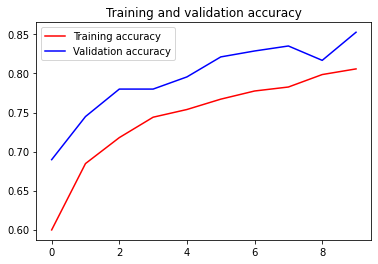

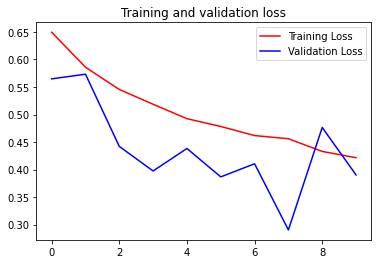

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()